In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statistics import mean

In [3]:
plt.style.use("seaborn-deep")

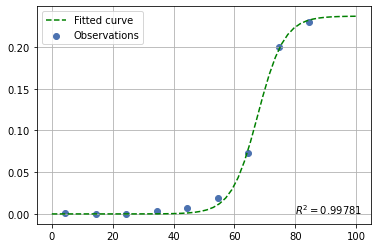

In [33]:
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

age_death = [
    0.000626537, 0.0003,        0.000311741,
    0.00347113,  0.006737667,   0.019181854,
    0.072922914, 0.2,           0.230151607,
    #0.24
]

age = [
    "0-9 år",    "10-19 år",    "20-29 år",
    "30-39 år",  "40-49 år",    "50-59 år",
    "60-69 år",  "70-79 år",    "80-89 år",
    #"90-99 år"
]


nw = [x.replace(' år', '').split('-') for x in age]
nw = [(int(x[0]), int(x[1])) for x in nw]
nw = [mean(x) for x in nw]
nw.sort()
age_dict = dict(zip(nw, age_death))

def logistic_mod(x, x_0, max_val, growth_rate):
    L = max_val
    k = growth_rate
    return L/(1+np.e**(-k*(x-x_0)))

def logistic_mod_fit(x, L, x_0, growth_rate):
    # L = 0.24
    return logistic_mod(x, x_0, L, growth_rate)

ydata = np.array(list(age_dict.values()))
xdata = np.array(list(age_dict.keys()))
popt, pcov = curve_fit(logistic_mod_fit, xdata, ydata, bounds=((0, 0, 0), (2, 100, 2)))
test_xdata = np.linspace(0,100)
test = logistic_mod_fit(test_xdata, *popt)
plt.scatter(xdata, ydata, label="Observations")
plt.plot(test_xdata, test, "g--", label="Fitted curve")
text_str = "$R^2= $"+str(round(r2_score(ydata, logistic_mod_fit(xdata, *popt)),5))
plt.text(80, 0.0, text_str)
plt.grid()
plt.legend()

In [34]:
popt

array([ 0.23705718, 67.6801843 ,  0.23108405])

In [6]:
folk = pd.read_csv('folk2.csv', delimiter="\t", encoding="utf-8")
folk = folk[["alder", "2020"]]
folk.columns = ["alder", "antal"]
folk.alder = folk.alder.apply(lambda x: int(x.replace(" år", "")))
folk["dødelighed"] = folk.alder.apply(lambda x: logistic_mod_fit(x, *popt))
folk["alle_smittet_gr"] = folk.antal * folk.dødelighed
folk["pct80_smittet_gr"] = folk.antal*0.8*folk.dødelighed
print("Alle smittet:", int(folk.alle_smittet_gr.sum()))
print("80% smittet:", int(folk.pct80_smittet_gr.sum()))
print("IFR for grundforløb:", round(folk.alle_smittet_gr.sum()/folk.antal.sum()*100,2))
procent_døde_gr_forløb = folk.alle_smittet_gr.sum()/folk.antal.sum()*100
folk["dødelighed_1pct"] = folk.dødelighed/procent_døde_gr_forløb
folk['alle_smittet_1pct'] = folk.antal * folk.dødelighed_1pct
print("Ved samlet IFR på 1% og ved 80% smittede (alle aldersgrupper smittes lige meget):",
      int((folk.alle_smittet_1pct*0.8).sum()))

Alle smittet: 233076
80% smittet: 186461
IFR for grundforløb: 4.0
Ved samlet IFR på 1% og ved 80% smittede (alle aldersgrupper smittes lige meget): 46582


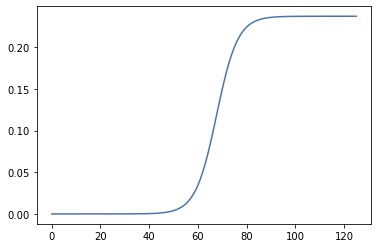

In [35]:
plt.plot(folk.dødelighed)

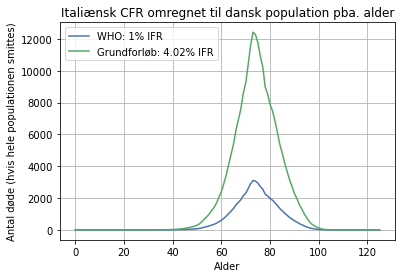

In [7]:
plt.plot(folk.alder, folk.alle_smittet_1pct, label="WHO: 1% IFR")
plt.plot(folk.alder, folk.alle_smittet_gr, label="Grundforløb: 4.02% IFR")
plt.title("Italiænsk CFR omregnet til dansk population pba. alder")
plt.grid()
plt.xlabel("Alder")
plt.ylabel("Antal døde (hvis hele populationen smittes)")

plt.legend()

In [8]:
(folk.alle_smittet_1pct*0.8).sum()

46582.104

In [9]:
### Italien 
it = pd.read_csv("age_data/italien.csv")
it_age = pd.Series([[x*10,x*10-1+10] for x in range(10)])
it_age.name = "age"
it = it.merge(it_age, right_index=True, left_index=True)
it["min_age"] = it.age.apply(lambda x: x[0])
it["max_age"] = it.age.apply(lambda x: x[1])
it['mean_age'] = it.age.apply(lambda x: mean(x))
it = it.drop(columns=["age"])
it.columns = ['deadliness', 'min_age', 'max_age', 'mean_age']

Text(0.5, 1.0, 'Italien: CFR over alder')

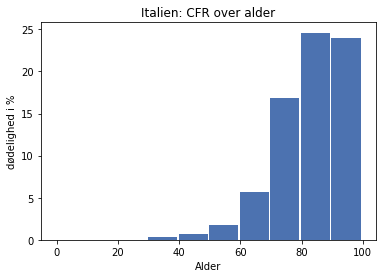

In [10]:
plt.bar(it.mean_age, it.deadliness, width=9.5)
plt.xlabel("Alder")
plt.ylabel("dødelighed i %")
plt.title("Italien: CFR over alder")

Passer godt med det andet datasæt fra Italien: [ 0.25019795 70.53264838  0.19831812]


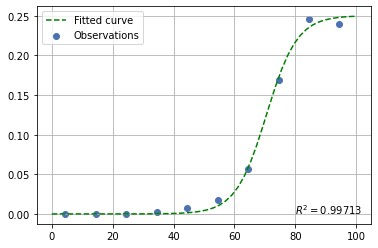

In [11]:
xdata = it.mean_age
ydata = it.deadliness/100

popt2, pcov = curve_fit(logistic_mod_fit, xdata, ydata, bounds=((0, 40, 0), (5, 120, 5)))

test_xdata = np.linspace(0,100)
test = logistic_mod_fit(test_xdata, *popt2)
plt.scatter(xdata, ydata, label="Observations")
plt.plot(test_xdata, test, "g--", label="Fitted curve")
text_str = "$R^2= $"+str(round(r2_score(ydata, logistic_mod_fit(xdata, *popt2)),5))
plt.text(80, 0.0, text_str)
plt.grid()
plt.legend()
print("Passer godt med det andet datasæt fra Italien:", popt2)

In [12]:
es = pd.read_csv("age_data\opendata_covid19_test_results.csv")
es.columns = ['id', 'gender', 'age', 'country', 'county', 'test_result',
       'test_date', 'result_time', 'analysis_time']
es.test_result = es.test_result.apply(
    lambda x: 1 if x == "P" else (0 if x == "N" else np.nan)
)
date_transform = lambda x: np.datetime64(x)
es.test_date = es.test_date.apply(date_transform)
es.result_time = es.result_time.apply(date_transform)
es.analysis_time = es.analysis_time.apply(date_transform)

print("Positive test i %:", round(es.test_result.sum()/es.test_result.count()*100,2),"%")
print("Samlet antal test:", len(es))

Positive test i %: 4.57 %
Samlet antal test: 26416


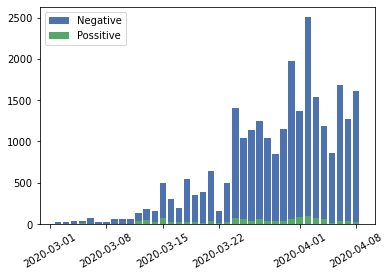

In [13]:
es_date = es[es.test_date > np.datetime64("2020-03-01")]

counted_test = es_date.groupby("test_date").count().id
plt.bar(counted_test.index, counted_test, label="Negative")
plt.xticks(rotation=30)
# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 10))

counted_test = es_date.groupby("test_date").test_result.sum()
plt.bar(counted_test.index, counted_test, label="Possitive")
plt.xticks(rotation=30)
# start, end = plt.get_xlim()
# ax.xaxis.set_ticks(np.arange(start, end, 10))

plt.legend()

In [14]:
def age_splitter(x):
    if type(x) is float: 
        return ["Unknown", "Unknown"]
    if len(x.split('-')) > 1:
         return [float(x) for x in x.split("-")]
    elif x=="üle 85":
        return [85, 89]

es = pd.read_csv("age_data\opendata_covid19_test_results.csv")
es.columns = ['id', 'gender', 'age', 'country', 'county', 'test_result',
       'test_date', 'result_time', 'analysis_time']
es.test_result = es.test_result.apply(
    lambda x: 1 if x == "P" else (0 if x == "N" else np.nan)
)   
date_transform = lambda x: np.datetime64(x)
es.test_date = es.test_date.apply(date_transform)
es.result_time = es.result_time.apply(date_transform)
es.analysis_time = es.analysis_time.apply(date_transform)

es["max_age"] = es.age.apply(lambda x: age_splitter(x)[1])
es["min_age"] = es.age.apply(lambda x: age_splitter(x)[0])
es = es[es.max_age != "Unknown"]
es.max_age = es.max_age.astype('int64')
es.min_age = es.min_age.astype('int64')
es["avg_age"] = (es.max_age+es.min_age)/2
es = es.sort_values("min_age")

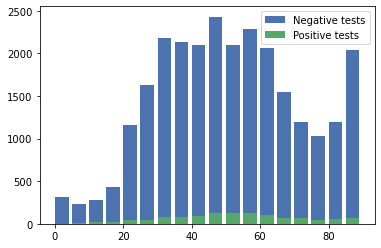

In [15]:
es_group_age = es.groupby("avg_age").test_result
plt.bar(es_group_age.count().index, es_group_age.count(), 4, label="Negative tests")
plt.bar(es_group_age.count().index, es_group_age.sum(), 4, label="Positive tests")
plt.legend()

Text(0, 0.5, 'Procent af test udført i perioden')

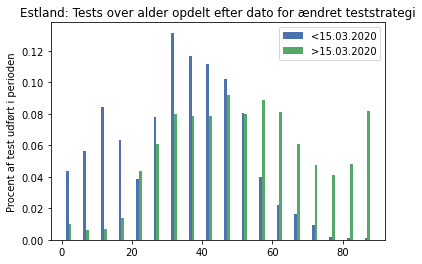

In [16]:
es_før = es[es.test_date < np.datetime64("2020-03-15")]
es_efter = es[es.test_date > np.datetime64("2020-03-15")]
es_før_group = es_før.groupby("avg_age").avg_age
plt.bar(es_før_group.count().index-0.4, 
        es_før_group.count()/es_før.avg_age.count(), 
        label="<15.03.2020")
es_efter_group = es_efter.groupby("avg_age").avg_age
plt.bar(es_efter_group.count().index+0.4, 
        es_efter_group.count()/es_efter.avg_age.count(), 
        label=">15.03.2020")
plt.legend()
plt.title("Estland: Tests over alder opdelt efter dato for ændret teststrategi")
plt.ylabel("Procent af test udført i perioden")
# plt.bar(es_efter)

In [17]:
print("Tests før den 15.03.2020:\t", len(es_før))
print("Tests efter den 15.03.2020:\t", len(es_efter))

Tests før den 15.03.2020:	 958
Tests efter den 15.03.2020:	 24880


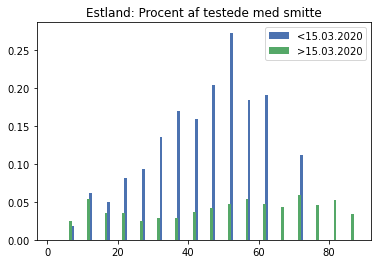

In [18]:
es_før_smit_pct = es_før.groupby("avg_age").test_result.sum()/es_før.groupby("avg_age").test_result.count()
es_efter_smit_pct = es_efter.groupby("avg_age").test_result.sum()/es_efter.groupby("avg_age").test_result.count()
plt.bar(es_før_smit_pct.index+0.3, 
        es_før_smit_pct, 
        label="<15.03.2020")
plt.bar(es_efter_smit_pct.index-0.3, 
        es_efter_smit_pct, 
        label=">15.03.2020")
plt.title("Estland: Procent af testede med smitte")
plt.legend()

In [19]:
def norm_dist(x, c, a, b):
    d1 = 1/(c*np.sqrt(2*np.pi))
    d20 = (-1/2)*(((x-a)/c)**2)
    d2 = np.e**d20
    return d1*d2*b

[15.69697495 47.20814081  8.61786218]


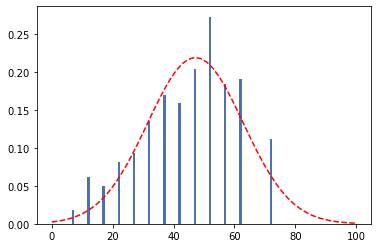

In [20]:
xdata = es_før_smit_pct.index
ydata = es_før_smit_pct
popt_dist, pcov = curve_fit(norm_dist, xdata, ydata, bounds=((0, 0, 0), (100, 120, 10)))
print(popt_dist)
plt.bar(xdata, ydata)
plt.plot(np.linspace(0,100), norm_dist(np.linspace(0,100), *popt_dist), "r--")

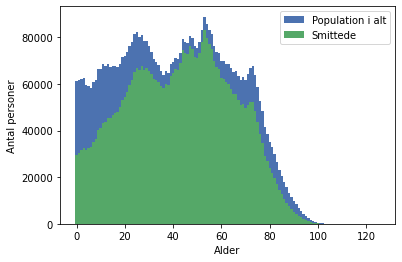

In [21]:
folk["basis_dist"] = folk.alder.apply(lambda x: norm_dist(x, *popt_dist))**0.15
folk["mod1Forløb"] = folk.antal*folk.basis_dist
folk["mod1Forløb80pct"] = folk.mod1Forløb/(folk.mod1Forløb.sum()/folk.antal.sum()*100)*80
plt.bar(folk.alder, folk.antal, 1, label="Population i alt")
plt.bar(folk.alder, folk.mod1Forløb80pct, 1, label="Smittede")
plt.xlabel("Alder")
plt.ylabel("Antal personer")
plt.legend()

Text(0, 2200, 'Antal døde: 43309')

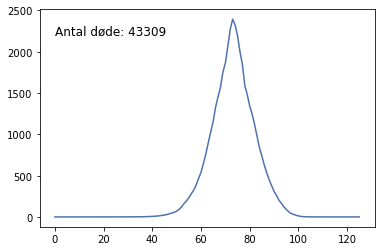

In [32]:
folk["mod1Dødelighed"] = folk.mod1Forløb80pct*folk.dødelighed_1pct
plt.plot(folk.mod1Dødelighed)
plt.text(0, 2200, "Antal døde: " + str(int(folk.mod1Dødelighed.sum())), fontsize=12)

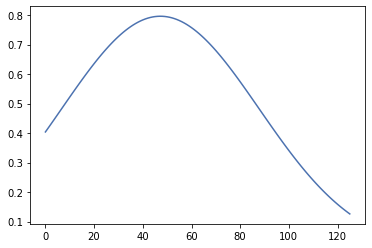

In [23]:
plt.plot(folk.basis_dist)

In [24]:
def yngste_først_radikalt_scenarie(folk):
    borgere = folk.antal.sum()*0.8
    for i in range(len(folk)):
        comp_nw = folk.antal.iloc[:i].sum()
        if comp_nw > borgere:
            return comp, borgere, i-1 
        else:
            comp = comp_nw
            
comp, borgere, i = yngste_først_radikalt_scenarie(folk)
folk["yngste_smittes"] = (folk.alder < i)*folk.antal
folk.at[i, "yngste_smittes"] = borgere - comp

64

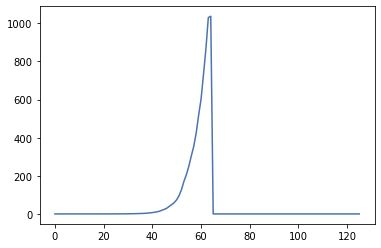

In [25]:
folk["yngste_smittes_døde"] = folk.yngste_smittes * folk.dødelighed_1pct
plt.plot(folk.yngste_smittes_døde)
i

In [26]:
print("Antal døde:", folk.yngste_smittes_døde.sum())
print("Procent smittede:", folk.yngste_smittes.sum()/folk.antal.sum())

Antal døde: 7072.138554634373
Procent smittede: 0.7999999313040905


In [27]:
(folk.alle_smittet_1pct*0.8).sum()

46582.104

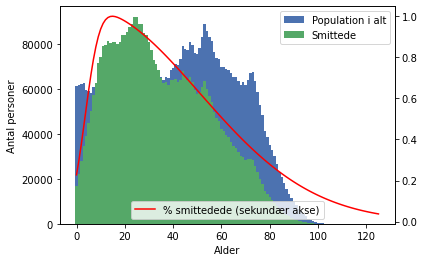

In [28]:
from scipy.stats import skewnorm

def skewed_norm(a, lenght):
    x = np.linspace(skewnorm.ppf(0.01, a), skewnorm.ppf(0.99, a), lenght)
    # plt.plot(skewnorm.pdf(x, a), label="Basis")
    return skewnorm.pdf(x, a)

skewed_norm_dist = skewed_norm(10, len(folk.alder))
skewed_dist_series = folk.alder.apply(lambda x: skewed_norm_dist[x])
folk['skewed_dist'] = skewed_dist_series/max(skewed_dist_series)
folk["mod2Forløb"] = folk.antal*folk.skewed_dist
folk["mod2Forløb80pct"] = folk.mod2Forløb/(folk.mod2Forløb.sum()/folk.antal.sum()*100)*80
plt.bar(folk.alder, folk.antal, 1, label="Population i alt")
plt.bar(folk.alder, folk.mod2Forløb80pct, 1, label="Smittede")
plt.xlabel("Alder")
plt.ylabel("Antal personer")
plt.legend()
plt.twinx()
plt.plot(folk.skewed_dist, "r", label="% smittedede (sekundær akse)")
plt.legend(loc=8)

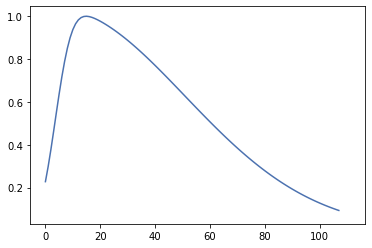

In [29]:
plt.plot(folk.mod2Forløb/folk.antal)

Text(0, 1302.485014154883, 'Antal døde: 23903')

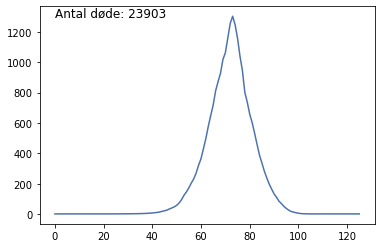

In [30]:
folk["mod2Dødelighed"] = folk.mod2Forløb80pct*folk.dødelighed_1pct
plt.plot(folk.mod2Dødelighed)
plt.text(0, max(folk.mod2Dødelighed), "Antal døde: " + str(int(folk.mod2Dødelighed.sum())), fontsize=12)

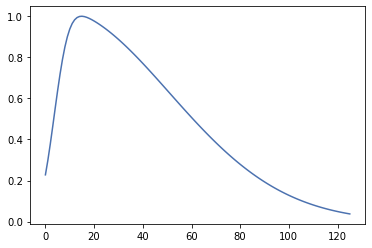

In [31]:
plt.plot(folk.skewed_dist/max(folk.skewed_dist))